In [10]:
from pandas import read_csv
from collections import Counter 
from matplotlib import pyplot
from numpy import mean
from numpy import std
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import make_scorer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PowerTransformer

In [4]:
filename = 'oil-spill.csv'
dataframe = read_csv(filename, header=None)


In [6]:
print(dataframe.shape)
dataframe.head()

(937, 50)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
0,1,2558,1506.09,456.63,90,6395000.0,40.88,7.89,29780.0,0.19,214.7,0.21,0.26,0.49,0.10,0.40,99.59,32.19,1.84,0.16,0.20,87.65,0,0.47,132.78,-0.01,3.78,0.22,3.20,-3.71,-0.18,2.19,0.0,2.19,310,16110,0.00,138.68,89,69,2850.00,1000.00,763.16,135.46,3.73,0,33243.19,65.74,7.95,1
1,2,22325,79.11,841.03,180,55812500.0,51.11,1.21,61900.0,0.02,901.7,0.02,0.03,0.11,0.01,0.11,6058.23,4061.15,2.30,0.02,0.02,87.65,0,0.58,132.78,-0.01,3.78,0.84,7.09,-2.21,0.00,0.00,0.0,0.00,704,40140,0.00,68.65,89,69,5750.00,11500.00,9593.48,1648.80,0.60,0,51572.04,65.73,6.26,0
2,3,115,1449.85,608.43,88,287500.0,40.42,7.34,3340.0,0.18,86.1,0.21,0.32,0.50,0.17,0.34,71.20,16.73,1.82,0.19,0.29,87.65,0,0.46,132.78,-0.01,3.78,0.70,4.79,-3.36,-0.23,1.95,0.0,1.95,29,1530,0.01,38.80,89,69,1400.00,250.00,150.00,45.13,9.33,1,31692.84,65.81,7.84,1
3,4,1201,1562.53,295.65,66,3002500.0,42.40,7.97,18030.0,0.19,166.5,0.21,0.26,0.48,0.10,0.38,120.22,33.47,1.91,0.16,0.21,87.65,0,0.48,132.78,-0.01,3.78,0.84,6.78,-3.54,-0.33,2.20,0.0,2.20,183,10080,0.00,108.27,89,69,6041.52,761.58,453.21,144.97,13.33,1,37696.21,65.67,8.07,1
4,5,312,950.27,440.86,37,780000.0,41.43,7.03,3350.0,0.17,232.8,0.15,0.19,0.35,0.09,0.26,289.19,48.68,1.86,0.13,0.16,87.65,0,0.47,132.78,-0.01,3.78,0.02,2.28,-3.44,-0.44,2.19,0.0,2.19,45,2340,0.00,14.39,89,69,1320.04,710.63,512.54,109.16,2.58,0,29038.17,65.66,7.35,0


### summarize the number of examples in each class

In [11]:
target = dataframe.values[:,-1]

In [17]:
counter = Counter(target)
print(counter)

Counter({0.0: 896, 1.0: 41})


In [48]:
#Notice the imbalance
for k,v in counter.items():
    per = v / len(target) * 100
    print('Class=%d, Count=%d, Percentage=%.3f%%' % (k, v, per))

Class=1, Count=41, Percentage=4.376%
Class=0, Count=896, Percentage=95.624%


### distribution of each variable by creating a histogram for each:
<html>
    <p>in order to get a feeling of what are the main characteristics of certain features. and be able to             understand if it’s present any pattern in the data distribution if it’s present any pattern in the data          distribution, we can then tailor-made our Machine Learning models to best fit our case study.</p>

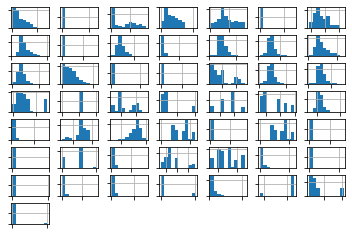

In [64]:
# create a histogram plot of each variable and science our variables are features of the images we do not need label 
ax = dataframe.hist()
#disable axis labels
for axis in ax.flatten():
    axis.set_title('')
    axis.set_xticklabels([])
    axis.set_yticklabels([])
pyplot.show()

<html>
<ul>
    <li>Running the snippet previous code creates the figure with one histogram subplot for each of the 50 variables in the dataset.</li>
    <li> We can see many different distributions, some with Gaussian-like distributions, others with seemingly exponential or discrete distributions.</li>
    <li> Depending on the choice of modeling algorithms, we would expect scaling the distributions to the same range to be useful, and perhaps the use of some power transforms.</li>
</ul>

    

## Model test and Base line result (Bench Mark for our Case): 
   <html>
        <h5 style="color:red">remember that we are handel unbalanced data So: </h5>
    <h6> We will evaluate candidate models using repeated stratified k-fold cross-validation: </h6>
      <ul>
        <li>Stratified means that each fold will contain the same mixture of examples by class, that is about 96% to 4% non-spill and spill. Repeated means that the evaluation process will be performed multiple times to help avoid fluke results and better capture the variance of the chosen model. We will use three repeats.</li>
     </ul>
    <h6> We are predicting class labels of whether a satellite image patch contains a spill or not. There are many measures we could use, although the authors of the paper chose to report the sensitivity, specificity, and the geometric mean of the two scores, called the <span style="color:blue"> G-mean</span>: </h6>
    <ul>
        <li>Sensitivity = TruePositives / (TruePositives + FalseNegatives)</li>
        <li>Specificity = TrueNegatives / (TrueNegatives + FalsePositives)</li>
        <li>G-Mean = sqrt(Sensitivity * Specificity)</li>
        <li style="color:red"> Note: poor performanc means low G-mean score.</li>
    </ul>
        

In [3]:
#function to load the dataset and split the columns into input and output variables. 
def load_dataset(full_path):
    # load the dataset as a numpy array
    data = read_csv(full_path, header=None)
    
    # drop unused columns see above you will notice that column 22 have the same value and column 1 is the index
    data.drop(22, axis=1, inplace=True)
    data.drop(0, axis=1, inplace=True)
    
    # retrieve numpy array
    data = data.values
    
    # split into input and output elements
    X, y = data[:, :-1], data[:, -1]
    
    # label encode the target variable to have the classes 0 and 1
    y = LabelEncoder().fit_transform(y)
    return X, y
    

function that will evaluate a given model on the dataset and return a list of G-Mean scores for each fold and repeat.

In [4]:
#evaluate model
def evaluate_model(X, y, model):
    # define evaluation procedure
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    
    # define the model evaluation metric
    metric = make_scorer(geometric_mean_score)
    
    # evaluate model
    scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
    
    return scores

Here we try to asamble what we have done and use DummyClassifier as our bench mark if you don't understand what is bench mark and what is used for here is another broject i desccused about it 

In [5]:
full_path = 'oil-spill.csv'
X, y = load_dataset(full_path)
model = DummyClassifier(strategy='uniform')
scores = evaluate_model(X, y, model)
print('Mean G-Mean: %.3f (%.3f)' % (mean(scores), std(scores)))

Mean G-Mean: 0.507 (0.167)


<html>
    <p style="color-background:red">
        In this case, we can see that the baseline algorithm achieves a G-Mean of about 0.50, close to the theoretical maximum of 0.5. This score provides a lower limit on model skill; any model that achieves an average G-Mean above about 0.50 (or really above 0.5) has skill, whereas models that achieve a score below this value do not have skill on this dataset.
    </p>

## Evaluate Models

<html>
    <p>In this section, we will evaluate a suite of different techniques on the dataset using the test harness developed in the previous section.</p>
    <p>The goal is to both demonstrate how to work through the problem systematically and to demonstrate the capability of some techniques designed for imbalanced classification problems.</p>

### Evaluate Probabilistic Models

<html>
    <p>We will evaluate the following probabilistic models with default hyperparameters in the dataset:</p>
    <ul>
        <li>Logistic Regression (LR)</li>
        <li>Linear Discriminant Analysis (LDA)</li>
        <li>Gaussian Naive Bayes (NB)</li>
    </ul>
    <p><span style="color:red">NOTE: </span>Both LR and LDA are sensitive to the scale of the input variables, and often expect and/or perform better if input variables with different scales are normalized or standardized as a pre-processing step.so we will use <span style="color:blue">StandardScaler </span></p>

In [7]:
# define models
models, names, results = list(), list(), list()
# LR
models.append(Pipeline(steps=[('t',StandardScaler()),('m',LogisticRegression(solver='liblinear'))]))
names.append('LR')

# LDA
models.append(Pipeline(steps=[('t', StandardScaler()),('m',LinearDiscriminantAnalysis())]))
names.append('LDA')

# NB
models.append(GaussianNB())
names.append('NB')


In [8]:
# evaluate each model
for i in range(len(models)):
    # evaluate the model and store results
    scores = evaluate_model(X, y, models[i])
    results.append(scores)
    # summarize and store
    print('>%s %.3f (%.3f)' % (names[i], mean(scores), std(scores)))

>LR 0.672 (0.203)
>LDA 0.755 (0.147)
>NB 0.707 (0.202)


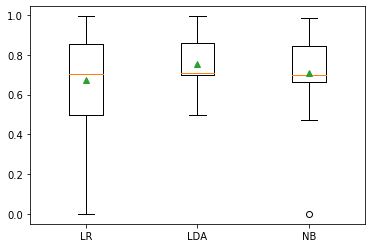

In [9]:
# plot the results
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

## We can do better

<html>
    <h5>Logistic Regression</h5>
    <span>Notice that logistic regression is sensitive to the scale of input variables and can perform better with normalized or standardized inputs </span>
    <p>we will try to make the the logistic regression work well by balance the class</p>

In [20]:
# define Balanced models
Bmodels, Bnames, Bresults = list(), list(), list()
# LR Balanced
Bmodels.append(LogisticRegression(solver='liblinear', class_weight='balanced'))
Bnames.append('Balanced')
# LR Balanced + Normalization
Bmodels.append(Pipeline(steps=[('t', MinMaxScaler()),('m', LogisticRegression(solver='liblinear', class_weight='balanced'))]))
Bnames.append('Balanced-Norm')
# LR Balanced + Standardization
Bmodels.append(Pipeline(steps=[('t', StandardScaler()),('m', LogisticRegression(solver='liblinear', class_weight='balanced'))]))
Bnames.append('Balanced-Std')
# LR Balanced  + Power
Bmodels.append(Pipeline(steps=[('t1', MinMaxScaler()), ('t2', PowerTransformer()),('m', LogisticRegression(solver='liblinear', class_weight='balanced'))]))
Bnames.append('Balanced-Power')

In [21]:
# evaluate each model
for i in range(len(Bmodels)):
    # evaluate the model and store results
    scores = evaluate_model(X, y, Bmodels[i])
    Bresults.append(scores)
    print('>%s %.3f (%.3f)' % (Bnames[i], mean(scores), std(scores)))

>Balanced 0.841 (0.118)
>Balanced-Norm 0.836 (0.088)
>Balanced-Std 0.834 (0.129)
>Balanced-Power 0.862 (0.124)


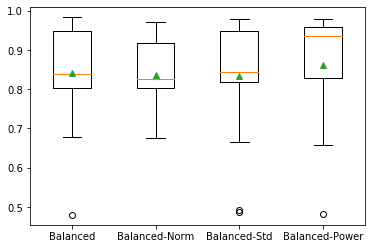

In [22]:
# plot the results
pyplot.boxplot(Bresults, labels=Bnames, showmeans=True)
pyplot.show()